# Rule Extraction and XAI metrics

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from lib.xai_auxiliary_rule_extraction import generateRuleHypercubes
from lib.xai_rule_metrics import (checkFidelity, 
                                  checkStability,
                                  checkDiversity)
from lib.xai_tools import plot_2D, loadDatasets

### 1. Load Data & Get Anomalies

In [2]:
# Load data
df_input, _, _ = loadDatasets(f_name = "seismic-bumps")
numerical_cols = ["gdenergy", "gdpuls"]  # 2D
categorical_cols = []
df_input = (df_input[numerical_cols + categorical_cols + ['target_class']]
            .drop_duplicates(subset = numerical_cols + categorical_cols)
            )
df_input.head()

,gdenergy,gdpuls,target_class
0,-72,-72,1
1,-70,-79,1
2,-81,-78,1
3,-23,40,1
4,-63,-52,1


In [3]:
# Train model & Get predictions
df_train = df_input.copy().drop(columns=['target_class'])
clf = IsolationForest()
y_pred_train = clf.fit_predict(df_train)
dist = clf.decision_function(df_train)
df_anomalies = df_input.copy()
df_anomalies["predictions"] = y_pred_train
df_anomalies["dist"] = dist
df_anomalies["score"] = clf.decision_function(df_train)
df_anomalies.head()

,gdenergy,gdpuls,target_class,predictions,dist,score
0,-72,-72,1,-1,-0.003437,-0.003437
1,-70,-79,1,-1,-0.022444,-0.022444
2,-81,-78,1,-1,-0.032470,-0.032470
3,-23,40,1,1,0.029973,0.029973
4,-63,-52,1,1,0.043875,0.043875


In [4]:
# Paths
path_folder = "pruebasIF"
file_template = "DT_IF"

method = "DecisionTree"
# list_methods = ["DecisionTree", "RuleFit", "FRL", "SkopeRules", "DecisionRuleList", "brlg", "logrr"]

### 2. Get Rules as Hypercubes

In [5]:
## 1. Get Rules (Hypercube)
# Define hyperparams for the XAI model
model_params = {}
# Generate rules hypercubes
df_rules_inliers, df_rules_outliers = generateRuleHypercubes(
    df_anomalies = df_anomalies,
    numerical_cols = numerical_cols,
    categorical_cols = categorical_cols,
    method = method,
    simplify_rules = True,
    model_params = model_params,
)
df_rules_inliers.head()

Depth tree:  14
Nodes tree:  81
leaf nodes not anomalies:  42
tree rules not anomalies:  19
tree rules anomalies:  13
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/18
Iter 1/18
Iter 2/18
Iter 3/18
Iter 4/18
Iter 5/18
Iter 6/18
Iter 7/18
Iter 8/18
Iter 9/18
Iter 10/18
Iter 11/18
Iter 12/18
Iter 13/18
Iter 14/18
Iter 15/18
Iter 16/18
Iter 17/18
No more improvements... finishing up
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/22
Iter 1/22
Iter 2/22
Iter 3/22
Iter 4/22
Iter 5/22
Iter 6/22
Iter 7/22
Iter 8/22
Iter 9/22
Iter 10/22
Iter 11/22
Iter 12/22
Iter 13/22
Iter 14/22
Iter 15/22
Iter 16/22
Iter 17/22
Iter 18/22
Iter 19/22
Iter 20/22
Iter 21/22
No more improvements... finishing up


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction
index,,,,,,
0,112.5,-48.5,87.5,-4.0,12,1
1,19.0,-74.5,-51.5,-67.5,8,1
2,112.5,-48.5,-34.5,-51.5,12,1
3,-48.5,-74.5,9.5,-51.5,11,1
4,-74.5,-77.5,-43.0,-67.5,7,1


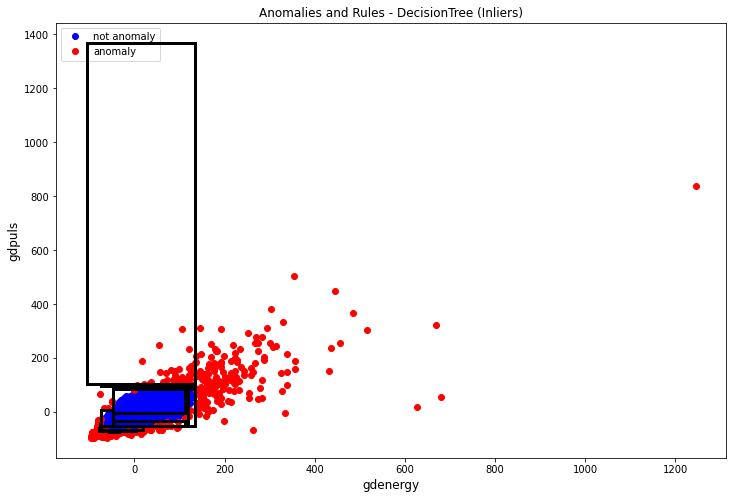

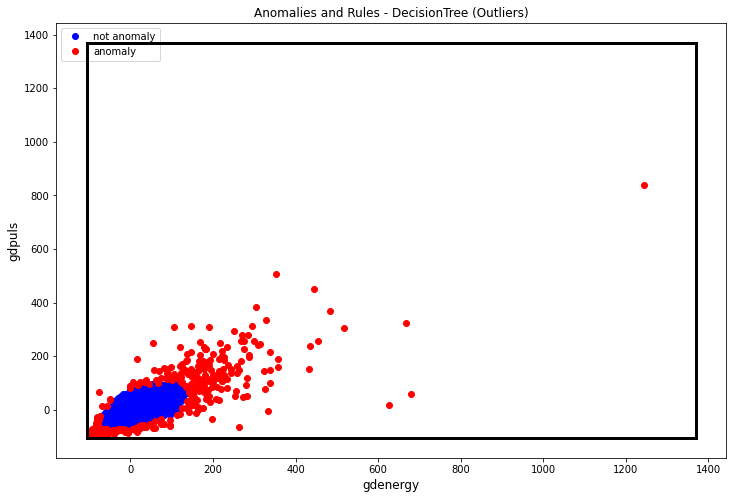

In [6]:
## 2. Plot Results [Only for 2D]
max_replace = df_input.max().max() + np.abs(df_input.max().max()) * 0.1
min_replace = df_input.min().min() - np.abs(df_input.min().min()) * 0.1
df_inliers_plot = (
    df_rules_inliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
) 
df_outliers_plot = (
    df_rules_outliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
)

plot_2D(df_inliers_plot, df_anomalies, title = method + ' (Inliers)')
plot_2D(df_outliers_plot, df_anomalies, title = method + ' (Outliers)')

### 3. XAI Metrics

In [7]:
# Precision (unsupervised model predictions vs ground truth)
target_names = ['outliers', 'inliers']
y_true = df_anomalies['target_class']
y_pred = df_anomalies['predictions']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    outliers       0.19      0.32      0.24       229
     inliers       0.92      0.86      0.89      2143

    accuracy                           0.80      2372
   macro avg       0.56      0.59      0.56      2372
weighted avg       0.85      0.80      0.83      2372



In [8]:
# Comprehensibility
n_rules_inliers = len(df_rules_inliers)
n_rules_outliers = len(df_rules_outliers)
mean_rule_size_inliers = df_rules_inliers['size_rules'].mean()
mean_rule_size_outliers = df_rules_outliers['size_rules'].mean()

In [9]:
# Fidelity/Representativeness/Focus on Abnormal
df_rules_inliers, df_rules_outliers, df_anomalies = checkFidelity(
    df_anomalies, df_rules_inliers, df_rules_outliers, numerical_cols, 
    categorical_cols
    )
df_rules_inliers.head()

Getting rule predictions...
Iter 0/2372
Iter 500/2372
Iter 1000/2372
Iter 1500/2372
Iter 2500/2372

Getting rule coverage...
Iter 0/2372
Iter 500/2372
Iter 1000/2372
Iter 1500/2372
Iter 2500/2372


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal
index,,,,,,,,,,,,,,,,,
0,112.5,-48.5,87.5,-4.0,12,1,904,1,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836
1,19.0,-74.5,-51.5,-67.5,8,1,157,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836
2,112.5,-48.5,-34.5,-51.5,12,1,170,4,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836
3,-48.5,-74.5,9.5,-51.5,11,1,154,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836
4,-74.5,-77.5,-43.0,-67.5,7,1,10,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836


In [10]:
# Stability
df_rules_inliers = checkStability(df_anomalies, df_rules_inliers, clf,
                                  numerical_cols, categorical_cols,
                                  using_inliers = True)
df_rules_outliers = checkStability(df_anomalies, df_rules_outliers, clf,
                                   numerical_cols, categorical_cols,
                                   using_inliers = False)
df_rules_inliers.head()

,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score
index,,,,,,,,,,,,,,,,,,
0,112.5,-48.5,87.5,-4.0,12,1,904,1,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79
1,19.0,-74.5,-51.5,-67.5,8,1,157,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79
2,112.5,-48.5,-34.5,-51.5,12,1,170,4,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79
3,-48.5,-74.5,9.5,-51.5,11,1,154,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79
4,-74.5,-77.5,-43.0,-67.5,7,1,10,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79


In [24]:
# Diversity
df_rules_inliers, _ = checkDiversity(df_rules_inliers, 
                                     numerical_cols, 
                                     categorical_cols)
df_rules_inliers.head()

Iter 1/1


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score,diversity_score
index,,,,,,,,,,,,,,,,,,,
0,112.5,-48.5,87.5,-4.0,12,1,904,1,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79,1.0
1,19.0,-74.5,-51.5,-67.5,8,1,157,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79,1.0
2,112.5,-48.5,-34.5,-51.5,12,1,170,4,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79,1.0
3,-48.5,-74.5,9.5,-51.5,11,1,154,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79,1.0
4,-74.5,-77.5,-43.0,-67.5,7,1,10,0,1989,1437,350,0.970946,0.722474,0.749157,0.1,1.0,0.932836,0.79,1.0
